In [22]:
'''@author: Zi Xian Leong (zxleong@psu.edu) '''

import numpy as np
import matplotlib.pyplot as plt
from random import uniform as rand
import scipy.io as sio
import os
from sklearn import preprocessing as pp
from random import randrange
from skimage.transform import rescale, resize
import scipy.ndimage.filters as fil
from random import uniform as rand
import random
from numpy.matlib import repmat
from scipy.signal import tukey
import matplotlib

from sklearn.model_selection import train_test_split
from tqdm import tqdm
# from utils.smooth import smooth, smooth_samedim

from scipy.interpolate import interp1d
import pandas as pd

from scipy.signal import butter, lfilter, sosfilt
import seaborn as sns
import string
from DLcodes.GPRNet import GPRNet

Using TensorFlow backend.


## See training progress of data set customized for field scenario (Figure 7)

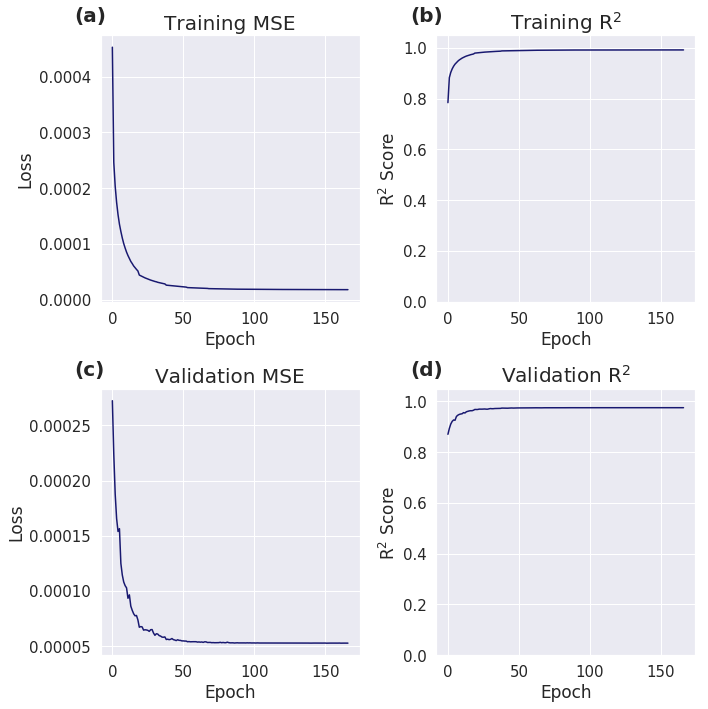

In [8]:
training_log = pd.read_csv('Field/Weights/weight_GPRNet_n32k10.csv')

mse_loss = training_log['loss']
val_mse_loss = training_log['val_loss']
acc = training_log['R2_score']
val_acc = training_log['val_R2_score']

def figure8():
    fig,axs = plt.subplots(2,2,figsize=(10,10))
    sns.set_theme(style='darkgrid')
    plt.rcParams['xtick.labelsize']=15
    plt.rcParams['ytick.labelsize']=15
    ax1 = axs[0,0]
    ax2 = axs[0,1]
    ax3 = axs[1,0]
    ax4 = axs[1,1]
    
    ax1.plot(mse_loss,'midnightblue')
    ax1.set_xlabel('Epoch', fontsize=17)
    ax1.set_ylabel('Loss', fontsize=17)
    ax1.set_title('Training MSE', fontsize=20)
    # ax1.set_xticks(np.arange(0,170,25))
    # ax1.set_xticklabels(np.arange(0,170,25),fontsize=15)

    ax1.text(-0.1, 1.05, '('+string.ascii_lowercase[0]+')', transform=ax1.transAxes, size=20, weight='bold')
    
    ax2.plot(acc,'midnightblue')
    ax2.set_ylim([0,1.05])
    ax2.set_xlabel('Epoch', fontsize=17)
    ax2.set_ylabel(r'R$^2$ Score', fontsize=17)
    ax2.set_ylim(0)
    ax2.set_title(r'Training R$^2$', fontsize=20)
    ax2.text(-0.1, 1.05, '('+string.ascii_lowercase[1]+')', transform=ax2.transAxes, size=20, weight='bold')

    ax3.plot(val_mse_loss,'midnightblue')
    ax3.set_xlabel('Epoch', fontsize=17)
    ax3.set_ylabel('Loss', fontsize=17)
    ax3.set_title('Validation MSE', fontsize=20)
    ax3.text(-0.1, 1.05, '('+string.ascii_lowercase[2]+')', transform=ax3.transAxes, size=20, weight='bold')

    ax4.plot(val_acc,'midnightblue')
    ax4.set_ylim([0,1.05])
    ax4.set_xlabel('Epoch', fontsize=17)
    ax4.set_ylabel(r'R$^2$ Score', fontsize=17)
    ax4.set_ylim(0)
    ax4.set_title(r'Validation R$^2$', fontsize=20)
    ax4.text(-0.1, 1.05, '('+string.ascii_lowercase[3]+')', transform=ax4.transAxes, size=20, weight='bold')

    fig.tight_layout()
    # matplotlib.rcdefaults()
    
figure8()

## Load Raw GPR Data and Processed GPR Data 

In [15]:
#load data
codata = sio.loadmat('Field/Data/rawfielddata/codata.mat')['co_data_cut']

#remove first arrivals
def taper_field(in_array): 
    window = tukey(400,0.3)
    window[100:len(window)]=1
    window = window**4
    out = in_array * window
    return out

codata_tapered = np.apply_along_axis(taper_field,0,codata)

#Apply bandpass
def butter_bandpass(lowcut, highcut, fs, order=5):
    # fs is sample rate in hz
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    # low = lowcut 
    # high = highcut 
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

bandpassCODATA = np.apply_along_axis(butter_bandpass_filter,0,codata_tapered,40e6,200e6,1000e6,order=3) 

#Apply time gain
dt = np.arange(0,1e-9*400,1e-9)
tfactor = np.exp(dt*1e6)**16 
timegainedCODATA = []
for i in range(208):
    timegainedCODATA.append(bandpassCODATA[:,i]*tfactor)
timegainedCODATA = np.array(timegainedCODATA)

#Apply max normalization
Norm_TG_BP_data = pp.normalize(timegainedCODATA,norm='max',axis=1)


print(Norm_TG_BP_data.shape)

#save
# np.save('Field/Data/pcsfielddata/ProcessedFieldData.npy',Norm_TG_BP_data)
# np.save('Field/Data/pcsfielddata/RawFieldData.npy',codata) #saving codata in npy form for easier accessibility


(208, 400)


## Show raw vs processed field data side by side - Figure 8

/home/zixian/.conda/envs/tfenv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


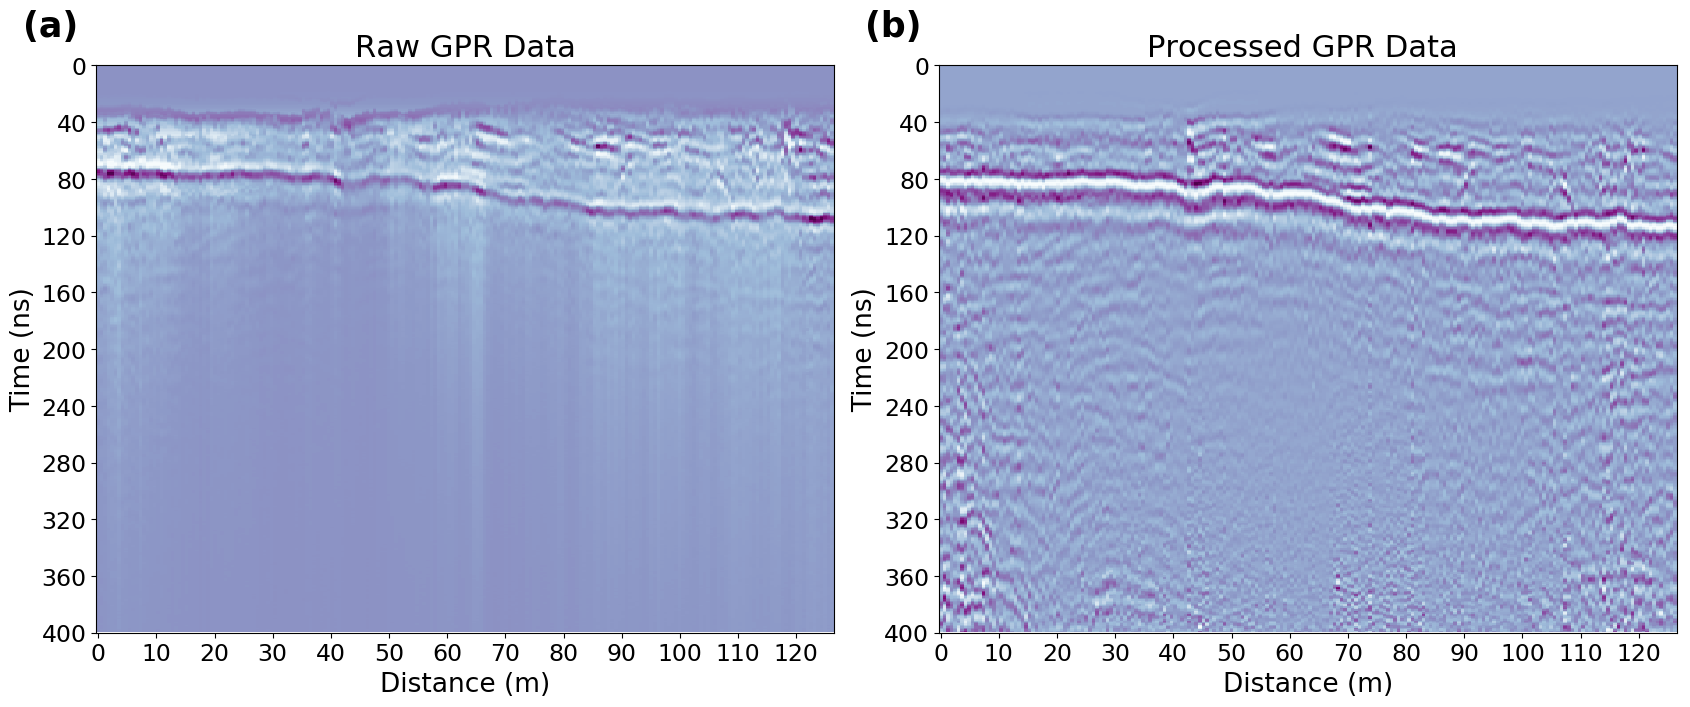

In [18]:
RawFieldData = np.load('Field/Data/pcsfielddata/RawFieldData.npy')
ProcessedFieldData = np.load('Field/Data/pcsfielddata/ProcessedFieldData.npy')
matplotlib.rcdefaults()
def figure8():
    fig, axs = plt.subplots(1,2,figsize=(17,8))
    
    xylabelfontsize=19
    tickfontsize=17
    titlefontsize=22
    ft2m = 0.3048
    m2ft = 1/ft2m
    
    ax = axs[0]
    ax.imshow(RawFieldData, cmap='BuPu_r')
    xticks = np.arange(0,208,10*m2ft/2) 
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.arange(0,127,10),fontsize=tickfontsize)
    ax.set_yticks(np.arange(0,420,40))
    ax.set_yticklabels(np.arange(0,420,40),fontsize=tickfontsize)
    ax.set_xlabel('Distance (m)', fontsize=xylabelfontsize)
    ax.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax.set_aspect(0.4)
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_title('Raw GPR Data',fontsize=titlefontsize)
    ax.text(-0.1, 1.05, '('+string.ascii_lowercase[0]+')', transform=ax.transAxes, size=25, weight='bold')
    # ax.grid('off')

    ax2 = axs[1]
    ax2.imshow(ProcessedFieldData.T, cmap='BuPu_r')
    xticks = np.arange(0,208,10*m2ft/2) 
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(np.arange(0,127,10),fontsize=tickfontsize)
    ax2.set_xlabel('Distance (m)',fontsize=xylabelfontsize)
    ax2.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax2.set_yticks(np.arange(0,420,40))
    ax2.set_yticklabels(np.arange(0,420,40),fontsize=tickfontsize)
    ax2.set_aspect(0.4)
    ax2.set_title('Processed GPR Data ',fontsize=titlefontsize)
    ax2.text(-0.1, 1.05, '('+string.ascii_lowercase[1]+')', transform=ax2.transAxes, size=25, weight='bold')
    ax2.grid('off')
    fig.tight_layout()
    
figure8()


## Apply trained weights to Raw GPR data (a)

In [19]:
ProcessedFieldData.shape

(208, 400)

In [40]:
weights_path = 'Field/Weights/weight_GPRNet_n32k10.h5'

cnn_model = GPRNet(im_width=1, im_height=400, neurons=32, kern_sz = 10,enable_dropout=False)
cnn_model.load_weights(weights_path)

FieldPrediction = np.squeeze(cnn_model.predict(np.expand_dims(ProcessedFieldData,axis=2)),axis=2) 

#Add smoothing
smoothed_model = fil.gaussian_filter(FieldPrediction,sigma=(0,3))

#save
#np.save('Field/Data/prediction/FieldPrediction.npy',FieldPrediction)


In [30]:
# Now we need to do two things:
#1) Convert FieldPrediction which is in time depth to spatial depth 
#2) Get obtain dielectric permittivity (epsilon or ep) model for forward data simulation of FieldPrediction

FieldPrediction = np.load('Field/Data/prediction/FieldPrediction.npy')

dt=1e-9
vel_dd_img = []
z_stack_length = []
for i in range(208):
    vel_line = FieldPrediction.T[:,i]
    depth_z = np.cumsum(vel_line * dt, axis=0) / 2
    depth_z = np.insert(depth_z[:399],0,0,axis=0)
    max_depth = np.max(depth_z)
    dest_depth = np.arange(0,max_depth,0.05)
    vel_dd = interp1d(depth_z, vel_line,kind='linear',bounds_error=False,fill_value=np.nan,axis=0)(dest_depth)
    vel_dd_img.append(vel_dd)
    z_stack_length.append(len(dest_depth))
vel_dd_img = np.array(vel_dd_img)
z_stack_length = np.array(z_stack_length)

canvas = np.tile(np.nan,(np.max(z_stack_length),208))

for i in range(208):
    lengthOfEachLine = len(vel_dd_img[i])
    canvas[:lengthOfEachLine,i]=vel_dd_img[i]

min_z = np.min(z_stack_length)

canvas_cut = []
for i in range(208):
    canvas_cut.append(canvas[:min_z-1,i])
canvas_cut  = np.array(canvas_cut) #bear in mind this is the velocity model

ep = 299792500**2 / canvas_cut**2 #convert to ep

# ep_fieldprediction = sio.savemat('Field/Data/prediction/ep_FieldPrediction.mat',{'ep':ep})

## Now, before continuing, run FD_prediction.m to run forward data simulation on ep

In [ ]:
#After running FD_prediction.m, Field/Data/prediction/rawgather_Stacked1D_fieldprediction.mat is created

In [ ]:
#process stacked 1D forward data - downsample, remove first arrival, time gain, max norm

stacked1D = sio.loadmat('Field/Data/prediction/rawgather_Stacked1D_fieldprediction.mat')['Stacked_1D']

#downsample
scale = 20
field_dest_tt = np.arange(0,1e-9*400,1e-9)
field_ori_tt = np.arange(0,(400*scale)*(1e-9/scale),1e-9/scale)
stacked1D_interp=[]
for i in range(207):
    line_interp = interp1d(field_ori_tt,stacked1D[:,i],kind='linear',fill_value='extrapolate')(field_dest_tt)
    stacked1D_interp.append(line_interp)
stacked1D_interp = np.array(stacked1D_interp)

#remove first arrival
stacked1D_recover = np.apply_along_axis(taper_field,1,stacked1D_interp)

#time gain
tfactor_1d = np.exp(np.arange(0,1e-9*400,1e-9) * 1e6) ** 5
fd_1d_stacked = []
for i in range(207):
    fd_1d_stacked.append(stacked1D_recover[i,:]*tfactor_1d)
fd_1d_stacked = np.array(fd_1d_stacked)

#max normalization
ForwDataFrPred = pp.normalize(fd_1d_stacked,norm='max',axis=1)

#save
# np.save('Field/Data/prediction/ForwDataFrPred.npy',ForwDataFrPred)

In [34]:
#load files for easier figure reproduction
ForwDataFrPred = np.load('Field/Data/prediction/ForwDataFrPred.npy')
FieldPrediction = np.load('Field/Data/prediction/FieldPrediction.npy').T
smoothed_model = fil.gaussian_filter(FieldPrediction,sigma=(0,3))
ProcessedFieldData = np.load('Field/Data/pcsfielddata/ProcessedFieldData.npy')

## Compare raw prediction, smooth prediction, forward data, and processed field data - Figure 9

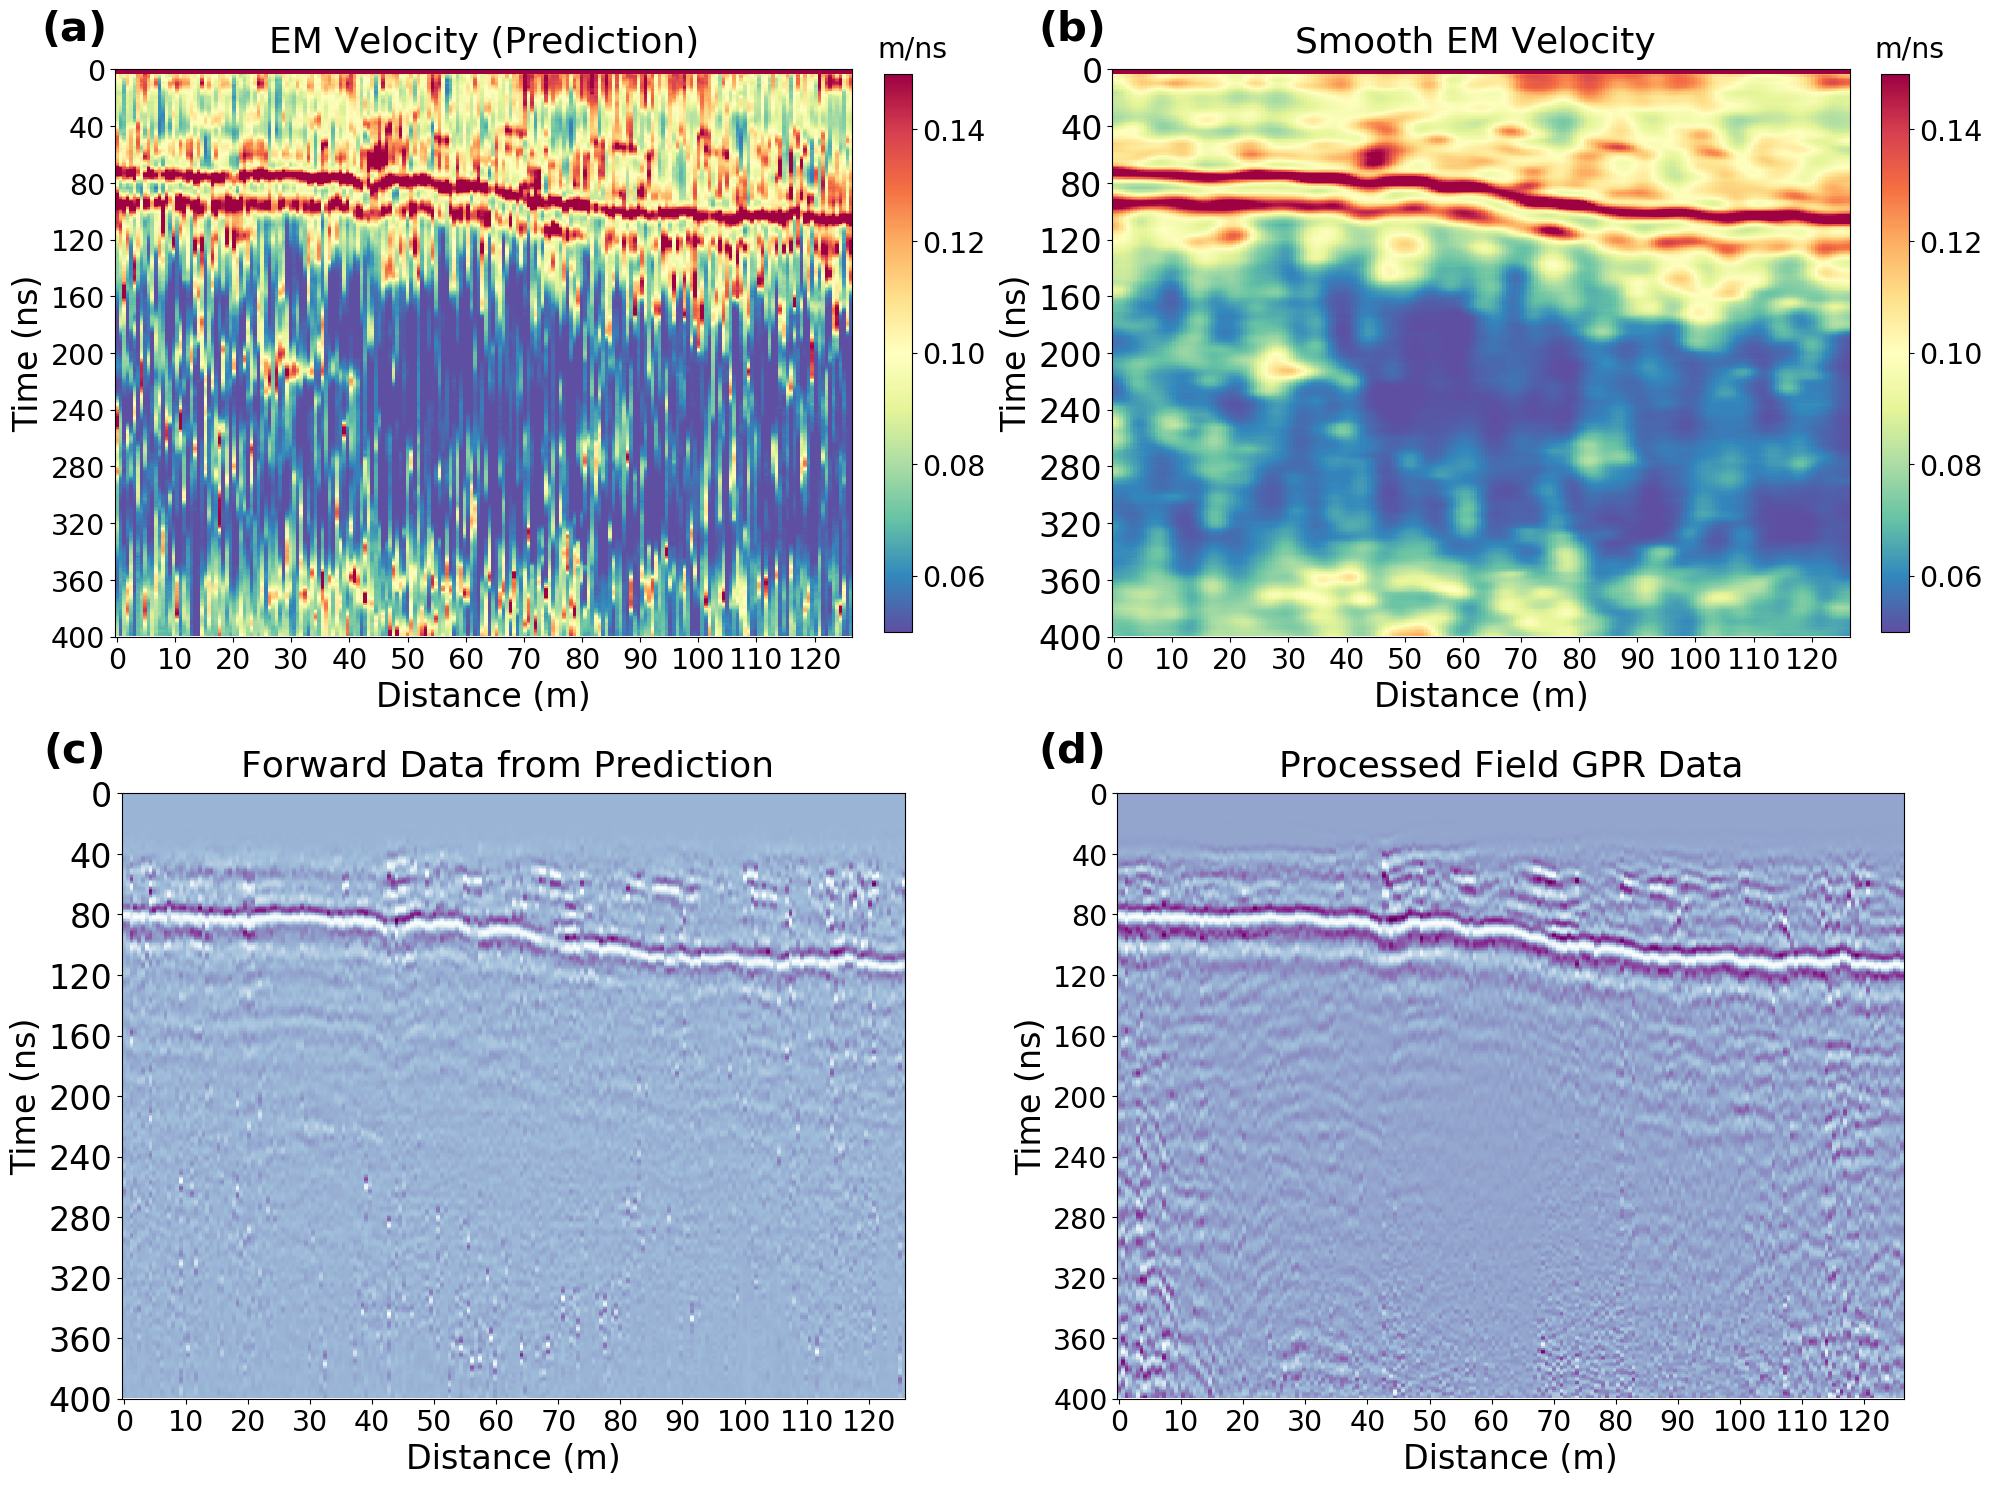

In [36]:
def figure9(wspace=0.5,hspace=0.05):
    fig, axs = plt.subplots(2,2,figsize=(20,15))
    # fig = plt.figure(figsize=(20,15))
    # gs = gridspec.GridSpec(2, 2)
    # gs.update(wspace=wspace, hspace=hspace) 
    
    xylabelfontsize=24
    tickfontsize=20.5
    titlefontsize=26
    titlePadSize=12
    subtilteFontSize = 30
    ft2m = 0.3048
    m2ft = 1/ft2m
    
    # Field Prediction
    ax = axs[0,0]
    im = ax.imshow(FieldPrediction/1e9, cmap='Spectral_r',vmin=0.05,vmax=0.15)
    xticks = np.arange(0,208,10*m2ft/2) 
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.arange(0,127,10),fontsize=tickfontsize)
    ax.set_yticks(np.arange(0,420,40))
    ax.set_yticklabels(np.arange(0,420,40),fontsize=tickfontsize)
    ax.set_xlabel('Distance (m)', fontsize=xylabelfontsize)
    ax.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax.set_aspect(0.4)
    cbar = fig.colorbar(im, ax=ax,fraction=0.035, pad=0.04)
    cbar.ax.tick_params(labelsize=tickfontsize)
    cbar.ax.set_xlabel('m/ns',fontsize=tickfontsize)
    cbar.ax.xaxis.set_label_coords(1,1.07)
    ax.set_title('EM Velocity (Prediction)',fontsize=titlefontsize,pad=titlePadSize)
    ax.text(-0.1, 1.05, '('+string.ascii_lowercase[0]+')', transform=ax.transAxes, size=subtilteFontSize, weight='bold')
    
    # Smoothed Model
    ax2 = axs[0,1]
    im2 = ax2.imshow(smoothed_model/1e9, cmap='Spectral_r',vmin=0.05,vmax=0.15)
    xticks = np.arange(0,208,10*m2ft/2) 
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(np.arange(0,127,10),fontsize=tickfontsize)
    ax2.set_xlabel('Distance (m)',fontsize=xylabelfontsize)
    ax2.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax2.set_yticks(np.arange(0,420,40)) #dz is 0.05, that means every 20 cell is 1m
    ax2.set_yticklabels(np.arange(0,420,40), fontsize=xylabelfontsize)
    ax2.set_aspect(aspect=0.4)
    ax2.set_title('Smooth EM Velocity ',fontsize=titlefontsize,pad=titlePadSize)
    ax2.text(-0.1, 1.05, '('+string.ascii_lowercase[1]+')', transform=ax2.transAxes, size=subtilteFontSize, weight='bold')
    cbar2 = fig.colorbar(im2, ax=ax2,fraction=0.035, pad=0.04)
    cbar2.ax.tick_params(labelsize=tickfontsize)
    cbar2.ax.set_xlabel('m/ns',fontsize=tickfontsize)
    cbar2.ax.xaxis.set_label_coords(1,1.07)

    # Forward Data from Prediction
    ax3 = axs[1,0]
    ax3.imshow(ForwDataFrPred.T, cmap='BuPu_r')
    xticks = np.arange(0,208,10*m2ft/2) 
    ax3.set_xticks(xticks)
    ax3.set_xticklabels(np.arange(0,127,10),fontsize=tickfontsize)
    ax3.set_xlabel('Distance (m)',fontsize=xylabelfontsize)
    ax3.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax3.set_yticks(np.arange(0,420,40)) #dz is 0.05, that means every 20 cell is 1m
    ax3.set_yticklabels(np.arange(0,420,40), fontsize=xylabelfontsize)
    ax3.set_aspect(0.4)
    ax3.set_title('Forward Data from Prediction ',fontsize=titlefontsize,pad=titlePadSize)
    ax3.text(-0.1, 1.05, '('+string.ascii_lowercase[2]+')', transform=ax3.transAxes, size=subtilteFontSize, weight='bold')
    # cbar3 = fig.colorbar(im3, ax=ax3,fraction=0.037, pad=0.04)
    # cbar3.ax.tick_params(labelsize=tickfontsize)
    
    # Processed Field Data
    ax4 = axs[1,1]
    ax4.imshow(ProcessedFieldData.T, cmap='BuPu_r')
    xticks = np.arange(0,208,10*m2ft/2) 
    ax4.set_xticks(xticks)
    ax4.set_xticklabels(np.arange(0,127,10),fontsize=tickfontsize)
    ax4.set_xlabel('Distance (m)',fontsize=xylabelfontsize)
    ax4.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax4.set_yticks(np.arange(0,420,40))
    ax4.set_yticklabels(np.arange(0,420,40),fontsize=tickfontsize)
    ax4.set_aspect(0.4)
    ax4.set_title('Processed Field GPR Data',fontsize=titlefontsize,pad=titlePadSize)
    ax4.text(-0.1, 1.05, '('+string.ascii_lowercase[3]+')', transform=ax4.transAxes, size=subtilteFontSize, weight='bold')
    plt.tight_layout()

figure9(wspace=0.3, hspace=0.3)

## Convert field prediction to spatial depth - Figure 10

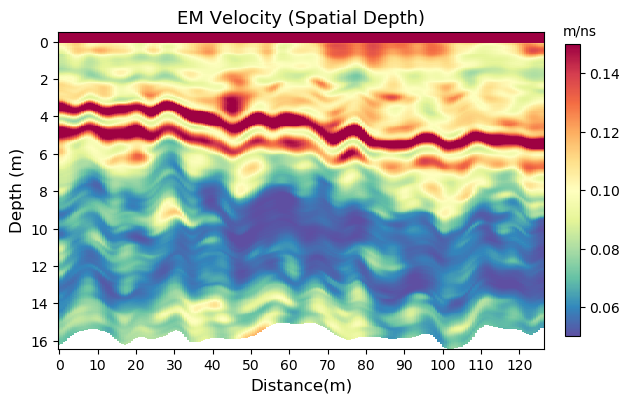

In [37]:
ft2m = 0.3048
m2ft = 1/ft2m

def convert2depth(in_img):
    dt=1e-9
    vel_dd_img_wtg = []
    z_stack_length = []
    for i in range(208):
        vel_line = in_img[:,i]
        depth_z = np.cumsum(vel_line * dt, axis=0) / 2
        depth_z = np.insert(depth_z[:399],0,0,axis=0)
        max_depth = np.max(depth_z)
        dest_depth = np.arange(0,max_depth,0.05)
        vel_dd = interp1d(depth_z, vel_line,kind='linear',bounds_error=False,fill_value=np.nan,axis=0)(dest_depth)
        vel_dd_img_wtg.append(vel_dd)
        z_stack_length.append(len(dest_depth))
    vel_dd_img_wtg = np.array(vel_dd_img_wtg)
    z_stack_length = np.array(z_stack_length)
    
    canvas_wtg = np.tile(np.nan,(np.max(z_stack_length),208))
    
    for i in range(208):
        lengthOfEachLine = len(vel_dd_img_wtg[i])
        canvas_wtg[:lengthOfEachLine,i]=vel_dd_img_wtg[i] 
    min_z = np.min(z_stack_length)

    return canvas_wtg, min_z

smoothed_model_dd, min_z = convert2depth(smoothed_model)


fig = plt.figure()
ax = plt.gca()
im = ax.imshow(smoothed_model_dd/1e9,cmap='Spectral_r',vmax=0.15,vmin=0.05)
ax.set_aspect(0.4)
xticks = np.arange(0,208,10*m2ft/2) 
ax.set_xticks(xticks)
ax.set_xticklabels(np.arange(0,127,10),fontsize=10)
ax.set_xlabel('Distance(m)',fontsize=12)
ax.set_yticks(np.arange(10,370,40)) #dz is 0.05, that means every 20 cell is 1m
ax.set_yticklabels(np.arange(0,18,2),fontsize=10)
ax.set_ylabel('Depth (m)',fontsize=12)
ax.set_title('EM Velocity (Spatial Depth)',fontsize=13)
cbar = fig.colorbar(im, ax=ax,fraction=0.028, pad=0.04)
cbar.ax.xaxis.set_label_coords(1,1.07)
cbar.ax.set_xlabel('m/ns',fontsize=10)
cbar.ax.tick_params(labelsize=10)
fig.tight_layout()    